Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [3]:
%matplotlib inline

In [4]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [5]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [6]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [7]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [8]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

In [9]:

def lane(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))

'''

def nominal(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))


def lane(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((ts[3] - posx)/(2 * rate)))
    
def nominal(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((posx - ts[3])/(2 * rate)))
'''

def barrier_u(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return + 1 + posx, + 2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return + 1 + posx, + 2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return + 1 + posx, + 2 + lane(posx)[0], lane(posx)[1]
                                                                      
def barrier_l(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return - 1 + posx, -2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return - 1 + posx, -2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return - 1 + posx, -2 + lane(posx)[0], lane(posx)[1]
    
def nominal(posx):
    return (barrier_u(posx)[1] + barrier_l(posx)[1]) * 0.5, (barrier_u(posx)[2] + barrier_l(posx)[2]) * 0.5

  

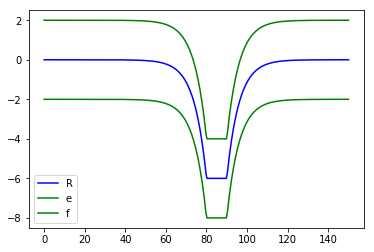

In [10]:
posx_path = np.linspace(0, 150, 300)
x_nominal = [[posx_path[i], nominal(posx_path[i])[0], 10, nominal(posx_path[i])[1]] for i in range(300)]
x_barrier_u = [[posx_path[i], barrier_u(posx_path[i])[1], 10, barrier_u(posx_path[i])[1]] for i in range(300)]
x_barrier_l = [[posx_path[i], barrier_l(posx_path[i])[1], 10, barrier_l(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_nominal)[:, 0]
posy_ = np.asarray(x_nominal)[:, 1]
posy_u = np.asarray(x_barrier_u)[:, 1]
posy_l = np.asarray(x_barrier_l)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_u, 'g')
_ = plt.plot(posx_, posy_l, 'g')
_ = plt.legend("Reference Path")


In [19]:
n = 2
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 100, checkpoint = 'checkpoints/mlp_H2_995.pt')

#agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])
#agent.train(num_epoch = 1000)


In [49]:
def agent_run(agent, x0s):
    agent_traj = []
    for x0 in x0s:
        agent_traj.append([])
        for _ in range(0, N):
            i = abs(int(x0[0]/0.5))
            x_nn = []
            if i >= N - H - 1:
                break
            x_nominal_ = x_nominal[i: i + H]
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            agent_traj[-1] = agent_traj[-1] + [[x0[:], u[0]]]
            x1 = dynamics.f(x0, u[0], i)[0]        
            x0 = x1[:]
    return agent_traj

x0s = []
batch_size = 20
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 1.0 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj = agent_run(agent, x0s)
        

print("Done")

Done


The red curve in the plot shows the trajectory of the regression model controller.

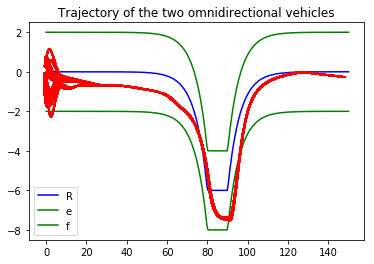

In [50]:
def draw_agent_traj(agent_traj):
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.legend(["Vehicle", "Reference Path"])
    
    posx_ = np.asarray(x_nominal)[:, 0]
    posy_ = np.asarray(x_nominal)[:, 1]
    posy_u = np.asarray(x_barrier_u)[:, 1]
    posy_l = np.asarray(x_barrier_l)[:, 1]
    _ = plt.plot(posx_, posy_, "b")
    _ = plt.plot(posx_, posy_u, 'g')
    _ = plt.plot(posx_, posy_l, 'g')
    _ = plt.legend("Reference Path")

    posx = []
    posy = []
    v = []
    theta = []
    for i in agent_traj:
        posx.append([])
        posy.append([])
        v.append([])
        theta.append([])
        for j in i:
            posx[-1].append(j[0][0])
            posy[-1].append(j[0][1])
            v[-1].append(j[0][2])
            theta[-1].append(j[0][3])
            plt.plot(posx[-1], posy[-1], "r")

    plt.show()

draw_agent_traj(agent_traj)

In [23]:
N = len(x_nominal)
H = 2  # Number of time steps in trajectory.
n = 30
n_init = 0
#n_end = 250
n_end = N - H - 1

# Initial state.
x0s = [[x_nominal[0][0] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][2] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][3] + 3.0 * (2 * random.random() - 1.0)] for i in range(1)]

# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []

# Instantenous state cost.
Q = 0.0 * np.eye(dynamics.state_size)
Q[3, 3] = 0.0

R = np.eye(dynamics.action_size)
R[0, 0] = 0.0
R[1, 1] = 0.0


q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[-0.0], [0.0]])
q1 = [150.0, 10.0]
q2 = [150.0, 10.0]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

def MPSC(agent, x0s):
    train_traj = []
    nn_traj = []
    mpc_traj= []
    traj = []
    for num in range(len(x0s)):
        train_traj.append([])
        nn_traj.append([])
        mpc_traj.append([])
        traj.append([])
        x0 = x0s[num]
        for step in range(n_init, n_end):
            print(">>>>>Step {} at {}".format(step, x0))
            i = abs(int(x0[0]/0.5))
            if i > n_end:
                break
            x_nominal_ = x_nominal[i: i + H]
            x_nn = []
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            #print("NN outputs control")
            agent_traj[-1] = agent_traj[-1] + [[x0, u[0, :]]]
            x1 = dynamics.f(x0, u[0], i)[0]
            #print("Get next state")

            if i <= n_end - n - 1:
                n_ilqr =  n 
            elif n_end > i:
                n_ilqr = n_end - i
            else:
                break

            x0_ = x1[:]
            us_ = []
            xs_ = []
            for _ in range(n_ilqr):
                i_ = abs(int(x0_[0]/0.5))
                x_nn_ = []
                for j in [x0_] + x_nominal[i_ : i_ + H]:
                    for k in j:
                        x_nn_.append(k)
                while len(x_nn_) < 4 *(H + 1):
                    for k in x_nominal[-1]:
                        x_nn_.append(k)
                u_ = agent.run([x_nn_])
                xs_.append(x0_[:])
                us_.append(u_[0])
                x1_ = dynamics.f(x0_, u_[0], i_)[0][:]
                x0_ = x1_[:]
            xs_ = np.asarray(xs_)
            us_init = np.asarray(us_[:-1])
            
            if (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[0].T) - b[0,0]\
                           <= 0)).all() == True and \
                (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[1].T) - b[1,0]\
                          <= 0)).all() == True:
                traj[-1].append([x0, u[0, :]])
                nn_traj[-1].append(traj[-1][-1])
                train_traj[-1].append([x_nn, u[0, :]])
                print("Utilize NN output {}".format(u))
            else: 
                x_nominal_ilqr = x_nominal[i + 1: i + 1 + n_ilqr]
                #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))


                cost_ = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:], \
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
                try:
                    xs, us = ilqr_.fit(x1, us_init, on_iteration=on_iteration)
                except TypeError as e:
                    print(e)
                    return traj, nn_traj, mpc_traj, train_traj
                us = np.exp(-np.logaddexp(0, -us))
                #print("MPC verifying")


                if (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == True:
                    traj[-1].append([x0, u[0, :]])
                    nn_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, u[0, :]])
                    print("Utilize NN output {}".format(u))
                else:
                    max_itr = 5
                    while (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).any() == False or \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).any() == False :
                        if max_itr == 0:
                            return  traj, nn_traj, mpc_traj, train_traj
                        max_itr -= 1    
                        cost = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:],\
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                        ilqr = iLQR(dynamics, cost, n_ilqr - 1)
                        xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)
                        us = np.exp(-np.logaddexp(0, -us))
                    traj[-1].append([x0, us[0]])
                    mpc_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, us[0]])
                    x1 = dynamics.f(x0, us[0], i)[0]
                    print("Utilize MPC output {}".format(us[0]))
            x0 = x1[:]
            
        return  traj, nn_traj, mpc_traj, train_traj
    
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)

>>>>>Step 0 at [-0.2544255711534067, -0.5982217953861673, 10.403791225256981, -1.0496425157182032]
Utilize NN output [[0.12580459 0.88092405]]
>>>>>Step 1 at [ 4.64486728e-03 -1.04948941e+00  1.04100485e+01 -6.81929910e-01]
Utilize NN output [[0.08056216 0.7260814 ]]
>>>>>Step 2 at [ 0.40881897 -1.37762152 10.41406789 -0.35887377]
Utilize NN output [[0.04542277 0.52574164]]
>>>>>Step 3 at [ 0.89640303 -1.56052288 10.41633747 -0.10783264]
Utilize NN output [[0.04391508 0.3627526 ]]
>>>>>Step 4 at [ 1.41424938 -1.61658107 10.41853182  0.0732222 ]
Utilize NN output [[0.04374364 0.2513654 ]]
>>>>>Step 5 at [ 1.93383462 -1.57846775 10.4207176   0.20147522]
Utilize NN output [[0.04268283 0.1525029 ]]
>>>>>Step 6 at [ 2.44438345 -1.47419003 10.42285045  0.28032438]
Utilize NN output [[0.04115163 0.06982908]]
>>>>>Step 7 at [ 2.94523297 -1.32999266 10.42490687  0.31665625]
Utilize NN output [[0.03953418 0.00697526]]
>>>>>Step 8 at [ 3.44060994 -1.16766628 10.42688255  0.32029202]
Utilize NN ou

Utilize NN output [[ 0.10290708 -0.00072832]]
>>>>>Step 80 at [ 4.11401147e+01 -7.58826313e-01  1.06104856e+01 -1.67335945e-02]
Utilize NN output [[ 0.09901571 -0.00020391]]
>>>>>Step 81 at [ 4.16706881e+01 -7.67705541e-01  1.06154203e+01 -1.68417764e-02]
Utilize NN output [[0.09529878 0.00014325]]
>>>>>Step 82 at [ 4.22015026e+01 -7.76646245e-01  1.06201708e+01 -1.67657422e-02]
Utilize NN output [[0.09174041 0.00035294]]
>>>>>Step 83 at [ 4.27325508e+01 -7.85550497e-01  1.06247450e+01 -1.65783273e-02]
Utilize NN output [[0.08833145 0.00045731]]
>>>>>Step 84 at [ 4.32638252e+01 -7.94358945e-01  1.06291501e+01 -1.63353876e-02]
Utilize NN output [[0.08506154 0.00048276]]
>>>>>Step 85 at [ 4.37953178e+01 -8.03041855e-01  1.06333930e+01 -1.60788211e-02]
Utilize NN output [[0.08192062 0.00045406]]
>>>>>Step 86 at [ 4.43270209e+01 -8.11591751e-01  1.06374799e+01 -1.58374108e-02]
Utilize NN output [[0.0789032  0.00038495]]
>>>>>Step 87 at [ 4.48589266e+01 -8.20016465e-01  1.06414169e+01 -1.56

iteration 0 accepted [891426.63300637] [91.94426543 -6.63505363 10.7086181   0.34710659] [-15.336274     0.28599656]
Utilize NN output [[ 0.02070294 -0.05262787]]
>>>>>Step 147 at [76.94132918 -3.53223301 10.8456319  -0.35265264]
iteration 0 accepted [3635321.28000243] [92.40032391 -6.45013759 10.64167735  0.46564389] [-49.27516      0.23043723]
Utilize MPC output [0.9991078  0.60735905]
>>>>>Step 148 at [ 7.74511316e+01 -3.71985943e+00  1.08836929e+01 -5.85920908e-02]
iteration 0 accepted [-4345.47594436] [92.3157823  -3.63385302 10.30184744  0.56929952] [-5.9340979e+02 -1.7795807e-01]
Utilize NN output [[ 0.0191136  -0.26469886]]
>>>>>Step 149 at [77.9944063  -3.75172751 10.88464843 -0.19936464]
iteration 0 accepted [-4347.29162191] [92.45623188 -3.14146284 10.169226    0.763011  ] [-1.0848961e+03 -9.1614944e-01]
Utilize NN output [[ 0.01656623 -0.23322882]]
>>>>>Step 150 at [78.52787919 -3.85951499 10.88547666 -0.32404283]
iteration 0 accepted [-4348.28102143] [92.3050923  -2.630730

Utilize NN output [[ 0.01675659 -0.11660929]]
>>>>>Step 184 at [95.60246579 -3.98670198 11.03031759  0.60370664]
Utilize NN output [[ 0.01814506 -0.1022122 ]]
>>>>>Step 185 at [96.05651275 -3.67359475 11.03122474  0.54753048]
Utilize NN output [[ 0.01882739 -0.09008427]]
>>>>>Step 186 at [96.52746283 -3.38645058 11.032166    0.49797746]
Utilize NN output [[ 0.01905629 -0.07995997]]
>>>>>Step 187 at [97.01209946 -3.12296371 11.0331187   0.45396464]
Utilize NN output [[ 0.01891923 -0.07143579]]
>>>>>Step 188 at [97.50790248 -2.88103453 11.03406455  0.41462356]
Utilize NN output [[ 0.01849178 -0.06418866]]
>>>>>Step 189 at [98.01287996 -2.6587741  11.03498903  0.37925903]
Utilize NN output [[ 0.01784447 -0.05797183]]
>>>>>Step 190 at [98.52544238 -2.4544904  11.03588116  0.34730889]
Utilize NN output [[ 0.01704087 -0.05258644]]
>>>>>Step 191 at [99.04431    -2.26666977 11.03673312  0.31831872]
Utilize NN output [[ 0.01613373 -0.0478788 ]]
>>>>>Step 192 at [99.56844316 -2.09395504 11.03753

Utilize NN output [[0.00276394 0.00459187]]
>>>>>Step 269 at [ 1.41970988e+02 -1.91737637e-01  1.10639097e+01 -7.46969852e-03]
Utilize NN output [[0.00250697 0.00446426]]
>>>>>Step 270 at [ 1.42524171e+02 -1.95869825e-01  1.10640350e+01 -5.00010577e-03]
Utilize NN output [[ 0.00504196 -0.01246487]]
>>>>>Step 271 at [ 1.43077372e+02 -1.98635912e-01  1.10642871e+01 -1.18953359e-02]
Utilize NN output [[ 0.00455146 -0.00701461]]
>>>>>Step 272 at [ 1.43630553e+02 -2.05216495e-01  1.10645147e+01 -1.57758575e-02]
Utilize NN output [[ 0.00411503 -0.00270751]]
>>>>>Step 273 at [ 1.44183715e+02 -2.13943825e-01  1.10647204e+01 -1.72737192e-02]
Utilize NN output [[0.00372512 0.00050458]]
>>>>>Step 274 at [ 1.44736873e+02 -2.23499874e-01  1.10649067e+01 -1.69945698e-02]
Utilize NN output [[0.0033751  0.00273581]]
>>>>>Step 275 at [ 1.45290043e+02 -2.32901659e-01  1.10650754e+01 -1.54809999e-02]
Utilize NN output [[0.00305974 0.00411612]]
>>>>>Step 276 at [ 1.45843234e+02 -2.41466298e-01  1.10652284

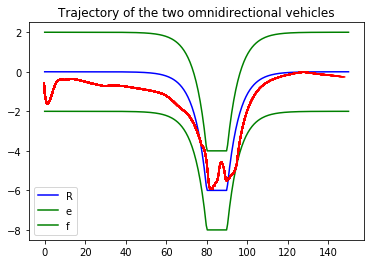

1


In [24]:
draw_agent_traj(traj)
print(len(train_traj))


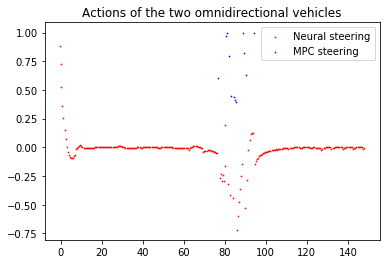

In [25]:
def draw_str(nn_traj, mpc_traj):
    str_nn = []
    posx_nn = []
    str_mpc = []
    posx_mpc = []
    for i in nn_traj[-1]:
        posx_nn.append(i[0][0])
        str_nn.append(i[1][1])
    for j in mpc_traj[-1]:
        posx_mpc.append(j[0][0])
        str_mpc.append(j[1][1])  

    _ = plt.title("Actions of the two omnidirectional vehicles")
    _ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
    _ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
    _ = plt.legend(["Neural steering", "MPC steering"])

draw_str(nn_traj, mpc_traj)

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

100
55516
[Epoch 1] avg_loss: 0.423
[Epoch 6] avg_loss: 0.413
[Epoch 11] avg_loss: 0.413
[Epoch 16] avg_loss: 0.408
[Epoch 21] avg_loss: 0.407
[Epoch 26] avg_loss: 0.408
[Epoch 31] avg_loss: 0.403
[Epoch 36] avg_loss: 0.409
[Epoch 41] avg_loss: 0.401
[Epoch 46] avg_loss: 0.405
[Epoch 51] avg_loss: 0.403
[Epoch 56] avg_loss: 0.399
[Epoch 61] avg_loss: 0.399
[Epoch 66] avg_loss: 0.397
[Epoch 71] avg_loss: 0.397
[Epoch 76] avg_loss: 0.397
[Epoch 81] avg_loss: 0.396
[Epoch 86] avg_loss: 0.399
[Epoch 91] avg_loss: 0.400
[Epoch 96] avg_loss: 0.399
Finished Training


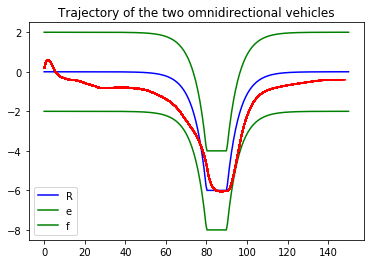

>>>>>Step 0 at [0.11427447138339719, 0.19786683130492677, 10.329780879837266, 0.40220852754601044]
Utilize NN output [[ 0.27990404 -0.29777652]]
>>>>>Step 1 at [ 0.58986083  0.40018078 10.34342169  0.25280038]
Utilize NN output [[ 0.2761303  -0.25027707]]
>>>>>Step 2 at [ 1.09091999  0.5296179  10.35688768  0.12600084]
Utilize NN output [[ 0.2720446  -0.21876222]]
>>>>>Step 3 at [ 1.60498839  0.59473592 10.370164    0.01448927]
Utilize NN output [[ 0.26787096 -0.18883082]]
>>>>>Step 4 at [ 2.12376918  0.60225321 10.38324613 -0.08227369]
Utilize NN output [[ 0.26324028 -0.15038313]]
>>>>>Step 5 at [ 2.64149595  0.55956155 10.39611232 -0.15976367]
Utilize NN output [[ 0.25903964 -0.07918484]]
>>>>>Step 6 at [ 3.1549945   0.47681794 10.40878217 -0.20083858]
Utilize NN output [[ 0.25528452 -0.02281339]]
>>>>>Step 7 at [ 3.66527867  0.37293264 10.42127616 -0.2127095 ]
Utilize NN output [[0.25216866 0.01669346]]
>>>>>Step 8 at [ 4.17490074  0.26286616 10.43362397 -0.20401195]
Utilize NN outp

Utilize NN output [[ 0.18963529 -0.01728528]]
>>>>>Step 122 at [67.04330966 -2.03260306 11.64577698 -0.14646352]
Utilize NN output [[ 0.18785827 -0.0084696 ]]
>>>>>Step 123 at [67.61959378 -2.11761642 11.65506094 -0.15139515]
Utilize NN output [[ 0.18556052 -0.00221817]]
>>>>>Step 124 at [68.19590778 -2.20554035 11.66423392 -0.1526878 ]
Utilize NN output [[0.1830918  0.00529649]]
>>>>>Step 125 at [68.77255801 -2.29427848 11.67328757 -0.14959885]
Utilize NN output [[0.18045057 0.00818438]]
>>>>>Step 126 at [69.34992407 -2.38130193 11.68221342 -0.14482202]
Utilize NN output [[0.17772523 0.00814219]]
>>>>>Step 127 at [69.92813758 -2.46563036 11.69100729 -0.14006619]
Utilize NN output [[0.17496322 0.00633811]]
>>>>>Step 128 at [70.50717768 -2.54726887 11.69966726 -0.13636129]
Utilize NN output [[ 0.17180516 -0.00369951]]
>>>>>Step 129 at [71.08694146 -2.62681989 11.70817399 -0.13852543]
Utilize NN output [[ 0.16900863 -0.00480778]]
>>>>>Step 130 at [71.66694961 -2.70768368 11.71654487 -0.1

Utilize NN output [[ 0.13131453 -0.00628277]]
>>>>>Step 240 at [ 1.36558279e+02 -4.33124483e-01  1.24202808e+01  6.22173810e-03]
Utilize NN output [[0.1311206  0.00256426]]
>>>>>Step 241 at [ 1.37179444e+02 -4.29259708e-01  1.24267995e+01  7.81417652e-03]
Utilize NN output [[ 0.13027245 -0.00171237]]
>>>>>Step 242 at [ 1.37800927e+02 -4.24403232e-01  1.24332765e+01  6.75021654e-03]
Utilize NN output [[ 0.12946372 -0.00415029]]
>>>>>Step 243 at [ 1.38422738e+02 -4.20205812e-01  1.24397138e+01  4.17014473e-03]
Utilize NN output [[ 0.12867008 -0.00527691]]
>>>>>Step 244 at [ 1.39044878e+02 -4.17611382e-01  1.24461120e+01  8.88010076e-04]
Utilize NN output [[0.12844427 0.0038492 ]]
>>>>>Step 245 at [ 1.39667343e+02 -4.17058627e-01  1.24524991e+01  3.28337955e-03]
Utilize NN output [[ 0.12757748 -0.00036173]]
>>>>>Step 246 at [ 1.40290123e+02 -4.15013795e-01  1.24588436e+01  3.05816014e-03]
Utilize NN output [[ 0.12675242 -0.00287048]]
>>>>>Step 247 at [ 1.40913220e+02 -4.13108259e-01  1.24

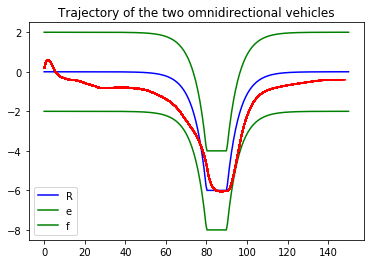

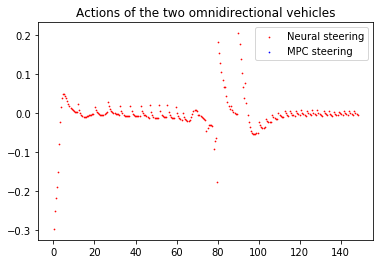

In [40]:
def train_temp(agent, train_traj = None, paths = None):
    n = 2
    
    #agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 1, checkpoint = 'checkpoints/mlp_H2_995.pt')
    
    X = []
    Y = []
    
    if train_traj is not None and train_traj is not []:
        print(len(train_traj))
        for i_traj in range(len(train_traj)):
            for i_xy in range(len(train_traj[i_traj])):
                X.append([x for x in train_traj[i_traj][i_xy][0]])
                Y.append([y for y in train_traj[i_traj][i_xy][1]])
    if train_traj is not None or paths is not None:
        agent_.data_process(X = X, Y = Y, paths = paths)
    
    agent_.train(num_epoch = 100)
    #for i in range(len(X)):
    #    print(agent_.run([X[i]]), Y[i])

    agent_temp_traj = agent_run(agent_, x0s)    
    draw_agent_traj(agent_temp_traj)
    
    # Random initial action path.
    us_init = np.zeros((n - 1, dynamics.action_size))

    J_hist = []
    q1 = [100.0, 10.0]
    q2 = [100.0, 10.0]

    traj_, nn_traj_, mpc_traj_, train_traj_ = MPSC(agent_, x0s)
    draw_agent_traj(traj_)
    draw_str(nn_traj_, mpc_traj_)
    return train_traj_

n = 2 
agent_ = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_temp_H2', batch_size = 500, checkpoint = 'checkpoints/mlp_H2_95.pt')
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']
train_traj_ = train_temp(agent_, 100 * train_traj, paths)  

180
75896
[Epoch 1] avg_loss: 0.289
[Epoch 6] avg_loss: 0.289
[Epoch 11] avg_loss: 0.289
[Epoch 16] avg_loss: 0.288
[Epoch 21] avg_loss: 0.288
[Epoch 26] avg_loss: 0.288
[Epoch 31] avg_loss: 0.288
[Epoch 36] avg_loss: 0.288
[Epoch 41] avg_loss: 0.288
[Epoch 46] avg_loss: 0.287
[Epoch 51] avg_loss: 0.287
[Epoch 56] avg_loss: 0.287
[Epoch 61] avg_loss: 0.287
[Epoch 66] avg_loss: 0.287
[Epoch 71] avg_loss: 0.287
[Epoch 76] avg_loss: 0.286
[Epoch 81] avg_loss: 0.286
[Epoch 86] avg_loss: 0.286
[Epoch 91] avg_loss: 0.286
[Epoch 96] avg_loss: 0.286
Finished Training


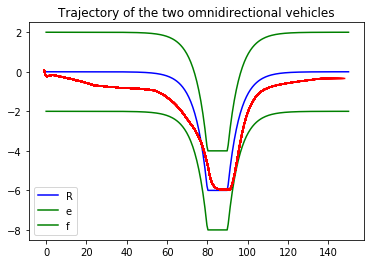

>>>>>Step 0 at [-0.9844915128044096, 0.08237201526886317, 10.230260786079716, -0.401265914369067]
Utilize NN output [[0.2599314  0.45303935]]
>>>>>Step 1 at [-0.5133168  -0.11754092 10.24297235 -0.18418277]
Utilize NN output [[0.2502056  0.30361956]]
>>>>>Step 2 at [-9.52932546e-03 -2.11393570e-01  1.02552280e+01 -3.32927782e-02]
Utilize NN output [[0.24772817 0.10814947]]
>>>>>Step 3 at [ 0.50325123 -0.22847177 10.26736705  0.0219469 ]
Utilize NN output [[0.24355713 0.02923949]]
>>>>>Step 4 at [ 1.01679445 -0.21719928 10.27930969  0.03695325]
Utilize NN output [[ 0.24063115 -0.01504373]]
>>>>>Step 5 at [ 1.53070396 -0.19820001 10.29111428  0.02922188]
Utilize NN output [[ 0.23740466 -0.01816324]]
>>>>>Step 6 at [ 2.04533118 -0.18315735 10.30276642  0.01987691]
Utilize NN output [[ 0.23446542 -0.02310774]]
>>>>>Step 7 at [ 2.56065551e+00 -1.72912949e-01  1.03142795e+01  7.97533949e-03]
Utilize NN output [[ 0.23173052 -0.02315081]]
>>>>>Step 8 at [ 3.07663766e+00 -1.68797729e-01  1.0325

Utilize NN output [[ 0.18699396 -0.00610029]]
>>>>>Step 116 at [61.76201337 -1.4345342  11.41229987 -0.08097773]
Utilize NN output [[ 0.18543585 -0.00977069]]
>>>>>Step 117 at [62.33098693 -1.48070936 11.42146683 -0.08655286]
Utilize NN output [[ 0.18385032 -0.0116883 ]]
>>>>>Step 118 at [62.90014895 -1.53009534 11.43055715 -0.09322743]
Utilize NN output [[ 0.1822112  -0.01256359]]
>>>>>Step 119 at [63.46941923 -1.58332124 11.43956821 -0.10040749]
Utilize NN output [[ 0.18050393 -0.01285721]]
>>>>>Step 120 at [64.0387389  -1.64067808 11.44849665 -0.10776114]
Utilize NN output [[0.17904088 0.00361083]]
>>>>>Step 121 at [64.60806347 -1.70226773 11.45735425 -0.10569422]
Utilize NN output [[ 0.1770832  -0.00579065]]
>>>>>Step 122 at [65.17795218 -1.76272698 11.466117   -0.10901146]
Utilize NN output [[ 0.17516257 -0.01146309]]
>>>>>Step 123 at [65.74807042 -1.82512376 11.47478665 -0.11558303]
Utilize NN output [[ 0.17321639 -0.01478774]]
>>>>>Step 124 at [66.31819455 -1.89131546 11.4833618

Utilize NN output [[0.13190876 0.00193702]]
>>>>>Step 230 at [ 1.27276957e+02 -4.64085716e-01  1.21095884e+01  1.59105440e-02]
Utilize NN output [[ 0.13139988 -0.00208724]]
>>>>>Step 231 at [ 1.27882523e+02 -4.54450017e-01  1.21161209e+01  1.46467650e-02]
Utilize NN output [[ 0.13091272 -0.00432382]]
>>>>>Step 232 at [ 1.28488427e+02 -4.45574853e-01  1.21226294e+01  1.20273847e-02]
Utilize NN output [[ 0.13042352 -0.00533314]]
>>>>>Step 233 at [ 1.29094677e+02 -4.38282902e-01  1.21291138e+01  8.79483023e-03]
Utilize NN output [[0.13055381 0.00855651]]
>>>>>Step 234 at [ 1.29701271e+02 -4.32947869e-01  1.21356047e+01  1.39838463e-02]
Utilize NN output [[0.12997939 0.00201022]]
>>>>>Step 235 at [ 1.30308154e+02 -4.24460765e-01  1.21420673e+01  1.52036040e-02]
Utilize NN output [[ 0.12946445 -0.00202036]]
>>>>>Step 236 at [ 1.30915348e+02 -4.15228515e-01  1.21485046e+01  1.39770360e-02]
Utilize NN output [[ 0.12897149 -0.00425838]]
>>>>>Step 237 at [ 1.31522874e+02 -4.06736546e-01  1.2154

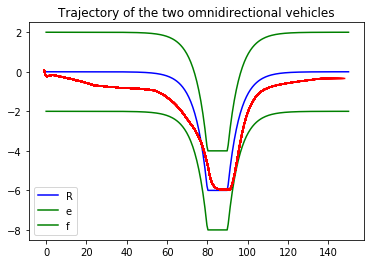

241
92061
[Epoch 1] avg_loss: 0.235
[Epoch 6] avg_loss: 0.236
[Epoch 11] avg_loss: 0.235
[Epoch 16] avg_loss: 0.236
[Epoch 21] avg_loss: 0.234
[Epoch 26] avg_loss: 0.234
[Epoch 31] avg_loss: 0.234
[Epoch 36] avg_loss: 0.235
[Epoch 41] avg_loss: 0.235
[Epoch 46] avg_loss: 0.234
[Epoch 51] avg_loss: 0.234
[Epoch 56] avg_loss: 0.235
[Epoch 61] avg_loss: 0.233
[Epoch 66] avg_loss: 0.233
[Epoch 71] avg_loss: 0.233
[Epoch 76] avg_loss: 0.234
[Epoch 81] avg_loss: 0.234
[Epoch 86] avg_loss: 0.234
[Epoch 91] avg_loss: 0.233
[Epoch 96] avg_loss: 0.232
Finished Training


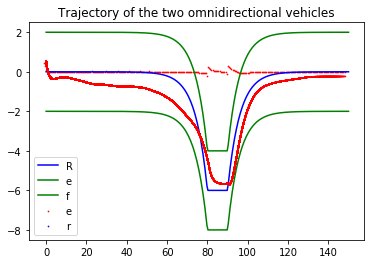

>>>>>Step 0 at [0.05571024465768981, 0.5120607896928517, 9.801215447576418, -0.6327299261317437]
Utilize NN output [[0.25064373 0.4080245 ]]
>>>>>Step 1 at [ 0.45115067  0.22208264  9.81349163 -0.44317735]
Utilize NN output [[0.24135451 0.2834854 ]]
>>>>>Step 2 at [ 0.89469039  0.01154856  9.82533037 -0.30768845]
Utilize NN output [[0.23590244 0.1872248 ]]
>>>>>Step 3 at [ 1.36316109 -0.13732236  9.83691145 -0.21677101]
Utilize NN output [[0.2325558  0.14664918]]
>>>>>Step 4 at [ 1.84377489 -0.24316861  9.84833406 -0.14515491]
Utilize NN output [[0.23110126 0.12438256]]
>>>>>Step 5 at [ 2.33129396 -0.31443563  9.85968772 -0.08422078]
Utilize NN output [[0.23014168 0.10393163]]
>>>>>Step 6 at [ 2.82281268 -0.35592987  9.87099586 -0.0331678 ]
Utilize NN output [[0.22866607 0.07594977]]
>>>>>Step 7 at [ 3.31637181e+00 -3.72306149e-01  9.88223397e+00  4.24528229e-03]
Utilize NN output [[0.22614783 0.03510158]]
>>>>>Step 8 at [ 3.81075702 -0.37020733  9.89335246  0.02158226]
Utilize NN outp

Utilize NN output [[ 0.17699823 -0.01124575]]
>>>>>Step 126 at [65.72286957 -1.77383263 11.09385418 -0.10549701]
Utilize NN output [[ 0.1755059  -0.01273279]]
>>>>>Step 127 at [66.27469433 -1.83226543 11.10254047 -0.11255941]
Utilize NN output [[ 0.17392057 -0.01191306]]
>>>>>Step 128 at [66.82652232 -1.89464252 11.11114986 -0.11917236]
Utilize NN output [[ 0.17201395 -0.0008867 ]]
>>>>>Step 129 at [67.37835086 -1.96071833 11.11966673 -0.11966497]
Utilize NN output [[0.16990015 0.00447435]]
>>>>>Step 130 at [67.93056703 -2.0271165  11.12808093 -0.11717733]
Utilize NN output [[0.16769353 0.00620492]]
>>>>>Step 131 at [68.48336184 -2.09218962 11.13638788 -0.11372493]
Utilize NN output [[0.16545635 0.00569782]]
>>>>>Step 132 at [69.03678797 -2.15540071 11.14458603 -0.1105523 ]
Utilize NN output [[ 0.16223592 -0.0024155 ]]
>>>>>Step 133 at [69.59081537 -2.21690046 11.15262739 -0.11189829]
Utilize NN output [[ 0.160016  -0.0029384]]
>>>>>Step 134 at [70.14515636 -2.27919047 11.1605606  -0.1

Utilize NN output [[0.12549888 0.0016183 ]]
>>>>>Step 254 at [ 1.37729416e+02 -2.47974318e-01  1.18728164e+01  2.78656064e-03]
Utilize NN output [[ 0.12494192 -0.00079819]]
>>>>>Step 255 at [ 1.38323210e+02 -2.46319671e-01  1.18790312e+01  2.31272378e-03]
Utilize NN output [[ 0.12439258 -0.00221081]]
>>>>>Step 256 at [ 1.38917314e+02 -2.44945669e-01  1.18852189e+01  9.99609055e-04]
Utilize NN output [[ 0.12384075 -0.00289543]]
>>>>>Step 257 at [ 1.39511729e+02 -2.44351486e-01  1.18913795e+01 -7.21026534e-04]
Utilize NN output [[0.12311719 0.00517582]]
>>>>>Step 258 at [ 1.40106451e+02 -2.44780296e-01  1.18975044e+01  2.35632803e-03]
Utilize NN output [[0.12255292 0.00140873]]
>>>>>Step 259 at [ 1.40701477e+02 -2.43378217e-01  1.19036016e+01  3.19434753e-03]
Utilize NN output [[ 0.12201166 -0.0010012 ]]
>>>>>Step 260 at [ 1.41296806e+02 -2.41476524e-01  1.19096721e+01  2.59845271e-03]
Utilize NN output [[ 0.12147724 -0.0023876 ]]
>>>>>Step 261 at [ 1.41892438e+02 -2.39928797e-01  1.1915

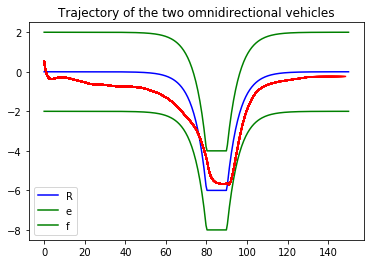

282
103254
[Epoch 1] avg_loss: 0.208
[Epoch 6] avg_loss: 0.208
[Epoch 11] avg_loss: 0.207
[Epoch 16] avg_loss: 0.207
[Epoch 21] avg_loss: 0.207
[Epoch 26] avg_loss: 0.207
[Epoch 31] avg_loss: 0.207
[Epoch 36] avg_loss: 0.207
[Epoch 41] avg_loss: 0.207
[Epoch 46] avg_loss: 0.207
[Epoch 51] avg_loss: 0.206
[Epoch 56] avg_loss: 0.207
[Epoch 61] avg_loss: 0.206
[Epoch 66] avg_loss: 0.206
[Epoch 71] avg_loss: 0.206
[Epoch 76] avg_loss: 0.206
[Epoch 81] avg_loss: 0.206
[Epoch 86] avg_loss: 0.206
[Epoch 91] avg_loss: 0.206
[Epoch 96] avg_loss: 0.206
Finished Training


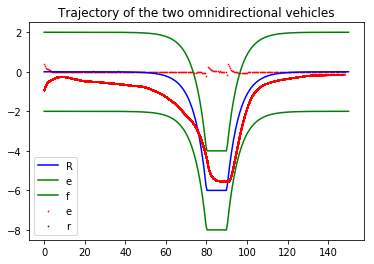

>>>>>Step 0 at [0.12964755046382126, -0.9265117981467266, 9.498539850152063, 0.29825887558333586]
Utilize NN output [[ 0.24494585 -0.15666124]]
>>>>>Step 1 at [ 0.58389326 -0.78686325  9.51054794  0.22445899]
Utilize NN output [[ 0.24156095 -0.13216858]]
>>>>>Step 2 at [ 1.04778068 -0.68095492  9.52239642  0.16197263]
Utilize NN output [[ 0.23765862 -0.08548114]]
>>>>>Step 3 at [ 1.5179564  -0.60412628  9.53406057  0.12137221]
Utilize NN output [[ 0.23659964 -0.04154493]]
>>>>>Step 4 at [ 1.99144074 -0.54637457  9.54567464  0.101579  ]
Utilize NN output [[ 0.23616996 -0.08040753]]
>>>>>Step 5 at [ 2.46655256 -0.49794651  9.55726839  0.06328429]
Utilize NN output [[ 0.23624547 -0.02628651]]
>>>>>Step 6 at [ 2.94374876 -0.46770711  9.5688657   0.05072582]
Utilize NN output [[0.23648043 0.00546957]]
>>>>>Step 7 at [ 3.42186647 -0.44343337  9.58047413  0.05334268]
Utilize NN output [[0.23592663 0.01030546]]
>>>>>Step 8 at [ 3.90049796 -0.41787764  9.59205636  0.05827906]
Utilize NN output 

Utilize NN output [[ 0.19874744 -0.00481309]]
>>>>>Step 118 at [59.93450319 -1.26985823 10.7862914  -0.07199186]
Utilize NN output [[ 0.19746134 -0.00473352]]
>>>>>Step 119 at [60.47266381 -1.30866849 10.79603811 -0.0745447 ]
Utilize NN output [[ 0.1961516  -0.00479116]]
>>>>>Step 120 at [61.01120801 -1.34888864 10.80572182 -0.07713096]
Utilize NN output [[0.19359392 0.00736999]]
>>>>>Step 121 at [61.55012607 -1.39053853 10.81528237 -0.07314913]
Utilize NN output [[ 0.19213982 -0.000364  ]]
>>>>>Step 122 at [62.08968071 -1.43007703 10.82477286 -0.07334596]
Utilize NN output [[ 0.19079062 -0.00484694]]
>>>>>Step 123 at [62.62969917 -1.46975638 10.8341983  -0.0759693 ]
Utilize NN output [[ 0.189477   -0.00742469]]
>>>>>Step 124 at [63.17008002 -1.51088789 10.84356038 -0.07999125]
Utilize NN output [[ 0.18815897 -0.00890558]]
>>>>>Step 125 at [63.71075609 -1.55422973 10.85285885 -0.08481953]
Utilize NN output [[ 0.186813   -0.00979082]]
>>>>>Step 126 at [64.25167823 -1.60022084 10.8620923

Utilize NN output [[0.12911786 0.00193871]]
>>>>>Step 244 at [ 1.29083318e+02 -2.20768644e-01  1.15793626e+01  1.25057152e-02]
Utilize NN output [[ 0.12861139 -0.00113665]]
>>>>>Step 245 at [ 1.29662400e+02 -2.13526423e-01  1.15857580e+01  1.18476298e-02]
Utilize NN output [[ 0.12810427 -0.00298105]]
>>>>>Step 246 at [ 1.30241807e+02 -2.06661508e-01  1.15921284e+01  1.01207485e-02]
Utilize NN output [[ 0.12758547 -0.00392005]]
>>>>>Step 247 at [ 1.30821542e+02 -2.00793952e-01  1.15984733e+01  7.84867352e-03]
Utilize NN output [[ 0.12704831 -0.00422522]]
>>>>>Step 248 at [ 1.31401606e+02 -1.96241127e-01  1.16047917e+01  5.39838219e-03]
Utilize NN output [[ 0.12649079 -0.0040991 ]]
>>>>>Step 249 at [ 1.31981994e+02 -1.93107939e-01  1.16110827e+01  3.01993522e-03]
Utilize NN output [[ 0.12591316 -0.00372217]]
>>>>>Step 250 at [ 1.32562702e+02 -1.91354233e-01  1.16173453e+01  8.59026224e-04]
Utilize NN output [[0.12493698 0.00326705]]
>>>>>Step 251 at [ 1.33143725e+02 -1.90855119e-01  1.16

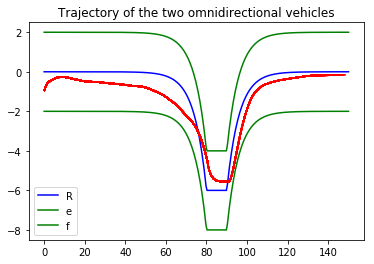

303
109092
[Epoch 1] avg_loss: 0.195
[Epoch 6] avg_loss: 0.195
[Epoch 11] avg_loss: 0.194
[Epoch 16] avg_loss: 0.194
[Epoch 21] avg_loss: 0.194
[Epoch 26] avg_loss: 0.194
[Epoch 31] avg_loss: 0.194
[Epoch 36] avg_loss: 0.194
[Epoch 41] avg_loss: 0.194
[Epoch 46] avg_loss: 0.193
[Epoch 51] avg_loss: 0.194
[Epoch 56] avg_loss: 0.193
[Epoch 61] avg_loss: 0.193
[Epoch 66] avg_loss: 0.193
[Epoch 71] avg_loss: 0.193
[Epoch 76] avg_loss: 0.193
[Epoch 81] avg_loss: 0.193
[Epoch 86] avg_loss: 0.193
[Epoch 91] avg_loss: 0.192
[Epoch 96] avg_loss: 0.193
Finished Training


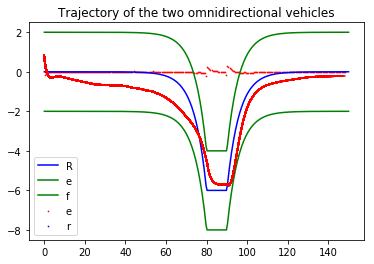

>>>>>Step 0 at [-0.07662825323909761, 0.8282088387649287, 9.924083695238014, -0.8064983186467539]
Utilize NN output [[0.24279866 0.50622356]]
>>>>>Step 1 at [ 0.26696614  0.46979987  9.93599057 -0.57477217]
Utilize NN output [[0.22756183 0.36263466]]
>>>>>Step 2 at [ 0.68417273  0.19956597  9.94717624 -0.40211814]
Utilize NN output [[0.2207363 0.2611615]]
>>>>>Step 3 at [ 1.14210912e+00  4.80917573e-03  9.95803723e+00 -2.75101850e-01]
Utilize NN output [[0.21850827 0.19333382]]
>>>>>Step 4 at [ 1.62154741 -0.13051639  9.96879202 -0.18002227]
Utilize NN output [[0.21870705 0.16065858]]
>>>>>Step 5 at [ 2.11219684 -0.21981092  9.97955629 -0.1006256 ]
Utilize NN output [[0.21858813 0.12675756]]
>>>>>Step 6 at [ 2.60891818 -0.2699632   9.99031489 -0.03771298]
Utilize NN output [[0.21572313 0.07002148]]
>>>>>Step 7 at [ 3.10834411e+00 -2.88806969e-01  1.00009368e+01 -2.79319891e-03]
Utilize NN output [[0.21324526 0.03249025]]
>>>>>Step 8 at [ 3.60865158 -0.29020443 10.01144032  0.01344773]


Utilize NN output [[ 0.17391609 -0.00050835]]
>>>>>Step 118 at [61.64816465 -1.42852616 11.09062978 -0.06892264]
Utilize NN output [[ 0.17265323 -0.00483471]]
>>>>>Step 119 at [62.20159275 -1.4667304  11.09917767 -0.07160362]
Utilize NN output [[ 0.17134799 -0.00761635]]
>>>>>Step 120 at [62.75534115 -1.50644869 11.1076622  -0.0758303 ]
Utilize NN output [[ 0.16999023 -0.00936496]]
>>>>>Step 121 at [63.30933809 -1.54853915 11.11608077 -0.08103129]
Utilize NN output [[ 0.168574   -0.01043429]]
>>>>>Step 122 at [63.86352646 -1.5935443  11.12443053 -0.0868305 ]
Utilize NN output [[ 0.16709787 -0.01109481]]
>>>>>Step 123 at [64.41785865 -1.64179857 11.13270852 -0.09300142]
Utilize NN output [[ 0.16556232 -0.01152933]]
>>>>>Step 124 at [64.97229277 -1.69351091 11.14091182 -0.09941877]
Utilize NN output [[ 0.16396792 -0.01186128]]
>>>>>Step 125 at [65.52678982 -1.74882067 11.14903753 -0.10602573]
Utilize NN output [[ 0.16191468 -0.00543515]]
>>>>>Step 126 at [66.08131086 -1.80783547 11.15706

Utilize NN output [[ 0.10544675 -0.00220558]]
>>>>>Step 245 at [ 1.32781080e+02 -2.53899243e-01  1.17724341e+01  6.15399279e-03]
Utilize NN output [[ 0.10490872 -0.002691  ]]
>>>>>Step 246 at [ 1.33369821e+02 -2.50276088e-01  1.17776604e+01  4.57001464e-03]
Utilize NN output [[ 0.10435852 -0.0027878 ]]
>>>>>Step 247 at [ 1.33958828e+02 -2.47584300e-01  1.17828594e+01  2.92833148e-03]
Utilize NN output [[ 0.10379688 -0.00264236]]
>>>>>Step 248 at [ 1.34548098e+02 -2.45858717e-01  1.17880307e+01  1.37160451e-03]
Utilize NN output [[0.10294909 0.00229051]]
>>>>>Step 249 at [ 1.35137627e+02 -2.45050116e-01  1.17931601e+01  2.72162972e-03]
Utilize NN output [[0.10239711 0.00058725]]
>>>>>Step 250 at [ 1.35727410e+02 -2.43444940e-01  1.17982621e+01  3.06790472e-03]
Utilize NN output [[ 0.10185008 -0.0005363 ]]
>>>>>Step 251 at [ 1.36317447e+02 -2.41634757e-01  1.18033371e+01  2.75153424e-03]
Utilize NN output [[ 0.1013034  -0.00120721]]
>>>>>Step 252 at [ 1.36907738e+02 -2.40010547e-01  1.18

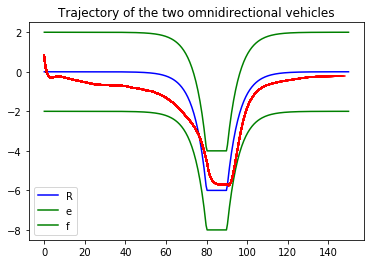

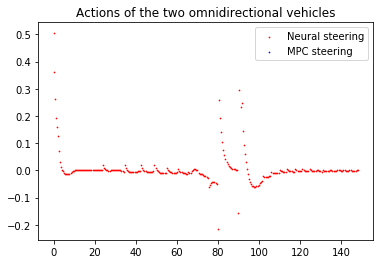

In [41]:
train_traj_aggr = 80 * train_traj[:] + 100 * train_traj_[:]

#raise TypeError
itr_train = 0
while itr_train < 4:
    # Initial state.
    x0s = [[x_nominal[0][0] + 1.0 * (2 * random.random() - 1.0), \
                  x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
                  x_nominal[0][2] + 1.0 * (2 * random.random() - 1.0), \
                  x_nominal[0][3] + 1.0 * (2 * random.random() - 1.0)] for i in range(1)]
    agent_ = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_temp_H2', batch_size = 500, checkpoint = 'checkpoints/mlp_temp_H2_95.pt')
    train_traj_ = train_temp(agent, train_traj_aggr, paths) 
    train_traj_aggr = train_traj_aggr + int(60 - 20 * itr_train + 1) * train_traj_[:]
    itr_train += 1

Done


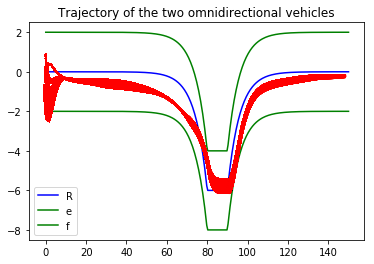

In [48]:
x0s = []
batch_size = 20
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 1.0 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj_ = agent_run(agent_, x0s)
        

print("Done")
draw_agent_traj(agent_traj_)

<h2>MPSC Guided Policy Search</h2>

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=\pi(x_k; \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& \pi(x_k; \theta)\\
u_k + \delta u_k &=& \pi(x_k + \delta x_k; \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x \pi(x_k; \theta) \delta x_k + \nabla_\theta \pi(x_k; \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.

Previously, we used L-2 norm of the perturbation on the model parameters, i.e. $||\delta \theta||^2_2$, to estimate the loss $L(\delta\theta)$. The optimization problem is as follows.

\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

It is a typical Quadratic Programming problem especially if the constrains are all convex. But it would be extremely computationally expensive for traditional QP solver because the size of $\nabla_\theta \pi(x; \theta)$ can be immensively large. 

Considering the difficulty, we can alternate the problem in the following way.

Firstly, given the current model parameter $\theta_i$, the linearization of the perturbation on the learning model can be rearranged in the following way.

$$\delta \theta_i^T \nabla_\theta \pi(x_k; \theta_i) \approx \delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)$$

Let the optimal control at state $x_k$ be $u^*_k$, which can be presumably obtained with the initial model parametere $\theta_0$, i.e. $u^*_k= \pi(x_k; \theta_0)$. The loss of the model based on this specific data point can be evaluated by using square error  
$$J_{(x_k, u^*_k)}(\theta_i) = ||\pi(x_k; \theta_i) - u^*_k||^2_2$$ 
or log likelihood with fixed covariance $\Sigma$
$$J_{(x_k, u^*_k)}(\theta_i) = -log[\frac{1}{(2\pi)^{\frac{n}{2}}\Sigma} exp\{-\frac{1}{2}[\pi(x_k; \theta_i) - u^*_k]^T \Sigma^{-1}[\pi(x_k,\theta_i)-u^*_k]\}$$

Either way, up to a scale of constant, $\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)= \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]$.

Evaluating the loss of the model based on a set $D=\{\tau = (x_0, u^*_0, \ldots, x_k, u^*_k, \ldots)\}$ of trajectories sampled from the roll-out of the unchanged model, then the increase on the model's loss due to the perturbation is $J_{D}(\theta_i+\delta\theta_i) - J_{D}(\theta_i)\approx \delta\theta_i^T \nabla_\theta J_{D}(\theta_i) + \frac{1}{2}\delta\theta_i^T \nabla^2_\theta J_{D}(\theta_i)\delta\theta_i$ and it is to be minimized.

Using Fisher Information Matrix to replace the second order derivative, the increase of loss turns out to be
\begin{eqnarray}
&&\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T]\delta\theta_i\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} [\delta\theta_i^T\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}[\delta\theta_i^T \nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T\delta\theta_i]\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} \{\delta\theta_i^T\nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]\} + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{\delta\theta_i^T \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T\nabla_\theta \pi(x_k; \theta_i)^T\delta\theta_i\}\\
&\approx& \mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k]\}+ \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)]^T\}\\
&\approx& \frac{1}{4|D|} \sum_{(x_k, u^*_k)\in D} \\
&&\begin{bmatrix} 1\\\delta x_k \\ \delta u_k\end{bmatrix}^T 
\begin{bmatrix} 
0 &-2[\pi(x_k; \theta_i) - u^*_k]^T\nabla_x \pi(x_k; \theta_i)^T &  2[\pi(x_k; \theta_i) - u^*_k]^T\\ 
-2\nabla_x \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \\
2[\pi(x_k; \theta_i) - u^*_k] & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T 
\end{bmatrix} 
\begin{bmatrix}1\\\delta x_k \\ \delta u_k\end{bmatrix} 
\end{eqnarray}

As a result, we get a quadratic objective function of which the variables are only $\delta x$ and $\delta u$. As $\pi(,)$ is considered, variable $\delta\theta$ is implicit in this objective function. After solving the $\delta x$ and $\delta u$, $\delta\theta$ can be directly derived and used to modify $\theta_i$. One thing to be stressed is that $\pi(x_k;\theta_i + \delta\theta_i)\neq u_k + \delta u_k$ because $\delta u_k$ is induced by both $\delta x_k$ and $\delta \theta_i$.

If we choose to directly constrain the trajectory, the $UNSAFE()$ function can be rewritten as a barrier function $b:X\rightarrow \mathbb{R}^+$ such that $UNSAFE(x)\leq \Rightarrow b(x)\approx 0$ and $UNSAFE(x)\geq 0 \Rightarrow b(x)\approx \infty$. One candidate is the exponential. Linearize $b$ in the same way as LQR.
\begin{eqnarray}
b(x_k + \delta x_k) = b(x_k) + \delta x_k^T \nabla_x b(x_k) + \delta x_k^T \nabla_x b(x_k) \delta x_k
\end{eqnarray}

For instance, $b(x) = w_1 exp[w_2*UNSAFE(x)]$, the barrier can be written as follows. It can be added to the objective. 
$$b(x_k+\delta x_k) = b(x_k) + \delta x_k^T w_1w_2 exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) ^T + \delta x_k^T \{w_1 w_2exp[w_2 UNSAFE(x)]\nabla_{x,x} UNSAFE(x)  + w_1 w_2^2  exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) \nabla_x UNSAFE(x)^T\}\delta_x$$

Actually, this constraint will not be needed to be directly enforced in the optimization if the following procedure works.

Firstly we need an initially feasible solution $\delta {\bf x}$ and $\delta {\bf u}$ to ensure the safety of ${\bf x} + \delta{\bf x}$. In fact they can be directly obtained by using MPSC. Once MPSC overrides the learning based controller and invokes a $\delta u_k=u_k^{safe} - u_k$, a safe trajectory ${\bf x} + \delta{\bf x}$ can be obtained in the end. To get $\delta {\bf x}$, the original unsafe trajectory ${\bf x}$ can be simulated at the very first time when MPSC is involved. From the feasible solution, the first feasible $\delta \theta_1$ can be obtained. Henceforth, an iLQR style backward and forward pass can be implemented. 

It is known that the optimal $\delta {\bf u}$ is affine in $\delta {\bf x}$, i.e. $\delta {\bf u} = k + K \delta {\bf x}$. Likewise, $\delta\theta^T \nabla_\theta \pi(x;\theta) = k^T + \delta {\bf x}^T [K^T + \nabla_x \pi(x; \theta)]$ in which $k, K$ should be updated via backward pass while $\delta \theta$ is updated at the end of the forward pass.  

During the forward pass, MPSC should keep monitoring and intervene when necessary. Therefore, the resulted trajectory after a forward pass may not be exctly be induced from the optimal solution. The iteration goes on with safety guarantee and terminates when the changes on $\delta \theta$ and $\delta {\bf x}$ are trivia.

**Initialization**

1. Learning based controller $\pi(;\theta_0)$
2. MPSC verifier

**Iteration** $i$

1. Run $\pi(;\theta_i)$ and the safe controller to generate a safe trajectory $\tau_i$. Train the learning model using $\tau_i$ with an online scheme to obtain $\hat{\theta_i}$ such that all $u$'s in the trajectory equals the outputs of $\pi(;\hat{\theta_i})$ despite some of them are originally generated by the MPSC.
2. Run $\pi(;\theta_0)$ at every state in the trajectory to obtain $u^*$'s.
3. Solve the QP to find $\delta x$'s and $\delta u$'s that should be applied to this trajectory. 
4. Solve $\delta \theta_i$ and add to $\theta_i$ to obtain $\theta_{i+1}$.



In [11]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

n = 2
checkpoint_0 = 'checkpoints/mlp_H2_995.pt'
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']
epoch_init = 0
num_epoch = 1
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X)
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

In [15]:
agent_0 = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H10_MPSC_0_', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_0.data_process(paths = paths)

if checkpoint_0 is not None:
    checkpoint = torch.load(checkpoint_0, map_location=device)
    agent_0.model.load_state_dict(checkpoint['model_state_dict'])
    agent_0.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    agent_0.model.eval()
    loss.backward()
    agent_0.optimizer.step()

27416


In [16]:
x0s = [[x_path[0][0] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][1] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][2] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][3] + 1.0 * (2 * random.random() - 1.0)]]  # Initial state.

agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H10_MPSC_', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

# Run MPSC guided controller and generate safe trajectory
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)
draw_agent_traj(traj)
draw_str(nn_traj, mpc_traj)

# Collect training trajectory
train_traj_aggr = [i for i in train_traj[:]]
    
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # Use the lately collected trajectory to modify the learning model
    X = []
    Y = []
    train_traj = train_traj_aggr[-1]
    if train_traj is not None and train_traj is not []:
        print(len(train_traj))
        for i_traj in range(len(train_traj)):
            for i_xy in range(len(train_traj[i_traj])):
                X.append([x for x in train_traj[i_traj][i_xy][0]])
                Y.append([y for y in train_traj[i_traj][i_xy][1]])
    if train_traj is not None or paths is not None:
        agent.data_process(X = X, Y = Y, paths = paths)
    agent.train(num_epoch = 100)
    
    # Run the latest model to get a sequence of actions
    us = []
    for xy in train_traj:
        x = [i for i in xy[0]]
        i = abs(int(x[0]/0.5))
        x_nn = []
        for j in [x] + x_nominal[i : i + H]:
            for k in j:
                x_nn.append(k)
        while len(x_nn) < 4 *(H + 1):
            for k in x_nominal[-1]:
                x_nn.append(k)
        u = agent.run([x_nn])[0]
        us.append(u.tolist())
    
    # Run the original model to get a sequence of actions
    us_0 = []
    for xy in train_traj:
        x = [i for i in xy[0]]
        i = abs(int(x[0]/0.5))
        x_nn = []
        for j in [x] + x_nominal[i : i + H]:
            for k in j:
                x_nn.append(k)
        while len(x_nn) < 4 *(H + 1):
            for k in x_nominal[-1]:
                x_nn.append(k)
        u_0 = agent_0.run([x_nn])[0]
        us_0.append(u_0.tolist())
    
    
    
    '''
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.float().to(agent.device), labels.float().to(agent.device)
        inputs.requires_grad = True
        
        agent.optimizer.zero_grad()
        
        outputs = agent.model(inputs)
        outputs = torch.reshape(outputs, (outputs.size()[0], agent.output_size))
        
        loss = agent.criterion(outputs, labels)
        loss.backward()
    
        # print statistics

  
        running_loss += loss.item()
        agent.optimizer.step()
        #agent.run()
    '''       
            
    if epoch % 5 == 0:
        print('[Epoch %d] avg_loss: %.3f' % (epoch + 1, running_loss/len(dataloader)))
        torch.save({'epoch': epoch, \
                    'model_state_dict': agent.model.state_dict(), \
                    'optimizer_state_dict': agent.optimizer.state_dict(), \
                    'loss': loss}, str('checkpoints/' + str(agent.model_name) + '_' + str(epoch) + '.pt'))
        x0 = x00

        N = 300
        n = 10
        agent_traj = []
        
        f_x = np.empty((N -n + 1, dynamics.state_size, dynamics.state_size))
        f_u = np.empty((N -n + 1, dynamics.state_size, dynamics.action_size))
        g_x = np.empty((N -n + 1, dynamics.action_size, dynamics.state_size, ))
        g_theta = np.empty((N -n + 1, dynamics.action_size, agent.num_parameters(agent.model)))
        '''
        print(f_x.shape)
        print(f_u.shape)
        print(g_x.shape)
        print(g_theta.shape)
        '''
        
        F_x = np.empty((N - n + 1, dynamics.state_size, dynamics.state_size))
        F_theta = np.empty((N - n + 1, dynamics.state_size, agent.num_parameters(agent.model)))
        
        # Search every time step
        for i in range(int(N - n) + 1):
            # Generate (state, control) pairs
            x = []
            for j in x0[0]:
                x.append(j)
            for j in range(len(x_path[i: i + n])):
                for k in range(len(x_path[j + i])):
                    x.append(x_path[j + i][k])
            x = np.asarray([x])
            x = torch.tensor(x, requires_grad = True).float().to(agent.device)
            
            agent.optimizer.zero_grad()
            u = agent.model(x)
            
            
            for j in range(dynamics.action_size):
                # Get gradient w.r.t input x[0:4] <<<< g_x
                g_x[i, j, :] = torch.autograd.grad(u[0, j], x, retain_graph = True\
                                                  )[0].cpu().numpy()[0, 0:dynamics.state_size]
                
                # Get gradient w.r.t model parameters theta <<<< g_theta
                torch.autograd.backward(u[0, j], retain_graph = True)
                k = 0
                for theta in agent.model.parameters():
                    g_theta_ = theta.grad.data.flatten() 
                    g_theta[i, j, k : k + g_theta_.size()[0]] = g_theta_.cpu().numpy()
                    k += g_theta_.size()[0]
            
            
            x = x.detach().cpu().numpy()
            u = u.detach().cpu().numpy()
            
            # Get dynamics w.r.t x <<<< f_x         
            f_x[i] = dynamics.f_x(x[0, 0:4], u[0], i)
            
            # Get dynamics w.r.t u <<<< f_u
            f_u[i] = dynamics.f_u(x[0, 0:4], u[0], i)
            
            # Record the trajectory
            agent_traj[-1].append([x[0], u[0]])
                              
            # Find next state
            x0 = dynamics.f(x[0, 0:4], u[0], i)
            
            # Calculate f_x + f_u g_x
            F_x[i] = f_x[i] + f_u[i].dot(g_x[i])
            # Calculate f_u g_theta
            F_theta[i] = f_u[i].dot(g_theta[i])
        
        draw_agent_traj(x_path, [agent_traj])
        
        # Define QP objective Q, p
        Q = np.eye(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))
        q = np.zeros((dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model), 1))
        
        # Define QP constraint Ax = b, Gx <= h
        A = np.zeros((dynamics.state_size * (N - n), \
                      dynamics.state_size * (N - n + 1) \
                      + agent.num_parameters(agent.model)))
        
        b = np.zeros((dynamics.state_size * (N - n), 1))
        G = np.zeros((2 * dynamics.state_size * (N - n + 1), \
                      dynamics.state_size * (N - n + 1)\
                      + agent.num_parameters(agent.model)))
        h = np.zeros((2 * dynamics.state_size * (N - n + 1), 1))
        
        for i in range(0, N - n + 1):
            x = agent_traj[i][0]
            u = agent_traj[i][1]
            
            if i <= N - n - 1:
                A[dynamics.state_size * i : dynamics.state_size * (i + 1), \
                  dynamics.state_size * i : dynamics.state_size * (i + 1)] = F_x[i, :]
                A[dynamics.state_size * i : dynamics.state_size * (i + 1), \
                  dynamics.state_size * (i + 1) : dynamics.state_size * (i + 2)] = - np.eye(dynamics.state_size)
                A[dynamics.state_size * i : dynamics.state_size * (i + 1),\
                  -agent.num_parameters(agent.model) : ] = F_theta[i, :]
                
            G[dynamics.state_size * 2 * i + 1, dynamics.state_size * i + 1] = 1.0
            G[dynamics.state_size * (2 * i + 1) + 1, dynamics.state_size * i + 1] =  - 1.0
            
            if i != 0:
                h[dynamics.state_size * 2 * i + 1] = nominal(x[0])[0] - x[1]
                h[dynamics.state_size * (2 * i + 1) + 1] = x[1] - nominal(x[0])[1]
        
            for j in range(dynamics.state_size):
                Q[i * dynamics.state_size + j] = 0.0
        
        
        print(Q.shape, q.shape, A.shape, b.shape, G.shape, h.shape)
        
        Q = numpy_sparse_to_spmatrix(Q)
        q = matrix(q)
        A = numpy_sparse_to_spmatrix(A)
        b = matrix(b)
        G = numpy_sparse_to_spmatrix(G)
        h = matrix(h)
        print("Starting solving QP")
        sol=solvers.qp(Q, q, G, h, A, b)
        #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))]}
        delta_theta = list(sol['x'])

        pickle.dump(delta_theta, open('model_parameter_perturbation_' + str(i) + '.p', 'wb'))
        print('QP solved')
        print('Model prameter updated')
        
        i = dynamics.state_size * (N - n + 1)
        for theta in agent.model.parameters():
            theta.data += torch.FloatTensor(delta_theta[i: i + theta.data.numel()]).reshape(theta.data.size()).to(agent.device)
            i += theta.data.numel()
        


NameError: name 'x_path' is not defined